In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [3]:
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

# 데이터 정리

In [16]:
def load_netflix_rating_data():
    netflix_csv_file = open('../dataset/recommendation/netflix_rating.csv', mode = 'w')
    with open('../dataset/recommendation/combined_data_4.txt') as f:
        for line in f:
            line = line.strip()
            if line.endswith(":"):
                movie_id = line.replace(":", "")
            else:
                row_data = []
                row_data = [item for item in line.split(',')]
                row_data.insert(0, movie_id)
                netflix_csv_file.write(','.join(row_data))
                netflix_csv_file.write('\n')
    netflix_csv_file.close()
    df = pd.read_csv('../dataset/recommendation/netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    df.to_pickle("../dataset/recommendation/netflix_rating.pkl")
    return df

In [17]:
if not os.path.isfile("../dataset/recommendation/netflix_rating.pkl"):
    netflix_rating_df = load_netflix_rating_data()
    netflix_rating_df['date'] = pd.to_datetime(netflix_rating_df['date'])
    netflix_rating_df.sort_values(by = 'date', inplace = True)
else:
    netflix_rating_df = pd.read_pickle("../dataset/recommendation/netflix_rating.pkl")

In [18]:
netflix_rating_df.head()

,movie_id,customer_id,rating,date
11119861,15105,510180,4,1999-11-11
15858849,15894,510180,3,1999-11-11
22579741,17064,510180,2,1999-11-11
19392456,16465,510180,3,1999-11-11
10669666,15057,510180,5,1999-11-11


In [19]:
def load_netflix_title_data():
    with open('../dataset/recommendation/movie_titles.csv', 'r', encoding='utf8') as file:
        import csv
        with open('../dataset/recommendation/movie_titles_tab.csv', 'w', encoding='utf8') as csvfile:
            csv_writer = csv.writer(csvfile, delimiter='\t')
            for line in  file.readlines():
                row = line.split(',', 2)
                row_list = [row[0],str(row[1]),row[2].replace('\n','')]
                csv_writer.writerow(row_list)
    df = pd.read_csv("../dataset/recommendation/movie_titles_tab.csv", sep='\t', header = None, names=['movie_id', 'year_of_release', 'movie_title'])
    df.to_pickle("../dataset/recommendation/netflix_titles.pkl")
    return df

In [20]:
if not os.path.isfile("../dataset/recommendation/netflix_titles.pkl"):
    netflix_titles_df = load_netflix_title_data()
else:
    netflix_titles_df = pd.read_pickle("../dataset/recommendation/netflix_titles.pkl")

In [21]:
netflix_titles_df.head()

,movie_id,year_of_release,movie_title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


# 데이터 정리(중복제거)

In [22]:
netflix_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26847523 entries, 11119861 to 23676206
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   movie_id     int64         
 1   customer_id  int64         
 2   rating       int64         
 3   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.0 GB


In [23]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

In [24]:
netflix_rating_df.isnull().sum()

movie_id       0
customer_id    0
rating         0
date           0
dtype: int64

In [25]:
netflix_titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         17770 non-null  int64  
 1   year_of_release  17763 non-null  float64
 2   movie_title      17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


In [72]:
netflix_titles_df.isnull().sum()

movie_id           0
year_of_release    7
movie_title        0
dtype: int64

In [73]:
netflix_titles_df[netflix_titles_df['year_of_release'].isnull()]

,movie_id,year_of_release,movie_title
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


In [75]:
netflix_titles_df.fillna(method="ffill", inplace=True)

In [77]:
netflix_titles_df[netflix_titles_df['year_of_release'].isnull()]

,movie_id,year_of_release,movie_title


In [79]:
df_new=netflix_rating_df.copy()

,movie_id,customer_id,rating,date
11119861,15105,510180,4,1999-11-11
15858849,15894,510180,3,1999-11-11
22579741,17064,510180,2,1999-11-11
19392456,16465,510180,3,1999-11-11
10669666,15057,510180,5,1999-11-11


In [80]:
df_new=df_new.merge(netflix_titles_df, on='movie_id')

In [82]:
df_new.head()

,movie_id,customer_id,rating,date,year_of_release,movie_title
0,15105,510180,4,1999-11-11,1991.0,My Girl
1,15105,261295,4,1999-12-24,1991.0,My Girl
2,15105,1267764,5,1999-12-30,1991.0,My Girl
3,15105,2105516,3,2000-01-06,1991.0,My Girl
4,15105,2108672,3,2000-01-06,1991.0,My Girl


In [84]:
print("Total number of movie ratings = "+str(df_new.shape[0]))
print("Number of unique users = "+str(len(np.unique(df_new["customer_id"]))))
print("Number of unique movies = "+str(len(np.unique(df_new["movie_id"]))))
print("Number of unique Movie Names = "+str(len(np.unique(df_new["movie_title"]))))

Total number of movie ratings = 26847523
Number of unique users = 475601
Number of unique movies = 4403
Number of unique Movie Names = 4376


In [87]:
df_new.groupby(['movie_title']).mean()['rating'].sort_values(ascending=False)

movie_title
Lord of the Rings: The Return of the King: Extended Edition    4.723270
Fullmetal Alchemist                                            4.605021
Trailer Park Boys: Season 3                                    4.600000
The Shawshank Redemption: Special Edition                      4.593384
Lord of the Rings: The Return of the King                      4.545121
                                                                 ...   
Vampiyaz                                                       1.503916
Rise of the Undead                                             1.502959
Absolution                                                     1.400000
Vampire Assassins                                              1.396761
Zodiac Killer                                                  1.346021
Name: rating, Length: 4376, dtype: float64

<AxesSubplot:xlabel='rating', ylabel='count'>

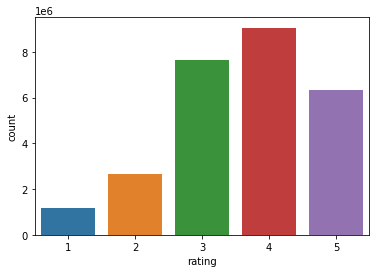

In [88]:
sns.countplot(x="rating", data=df_new)

In [89]:
df_new.groupby(['movie_title']).count()['rating'].sort_values(ascending=False)

movie_title
Independence Day                       216596
The Patriot                            200832
The Day After Tomorrow                 196397
The Green Mile                         181426
Con Air                                178068
                                        ...  
Frank Zappa: The Dub Room Special          36
Danielle Steel's Once in a Lifetime        36
My Wife's Murder                           29
Ah! My Goddess                             23
Mobsters and Mormons                        3
Name: rating, Length: 4376, dtype: int64

In [91]:
movie_count=df_new.groupby(['movie_title']).count()['rating'].sort_values(ascending=False)
mean_ratings=df_new.groupby(['movie_title']).mean()['rating'].sort_values(ascending=False)
ratings=pd.concat([movie_count,mean_ratings],axis=1)
ratings.columns=['No. of Ratings','Avg. Rating']
ratings.head()

,No. of Ratings,Avg. Rating
movie_title,,
Independence Day,216596,3.724238
The Patriot,200832,3.783854
The Day After Tomorrow,196397,3.442166
The Green Mile,181426,4.306941
Con Air,178068,3.454411


array([[<AxesSubplot:title={'center':'No. of Ratings'}>,
        <AxesSubplot:title={'center':'Avg. Rating'}>]], dtype=object)

<Figure size 1080x1080 with 0 Axes>

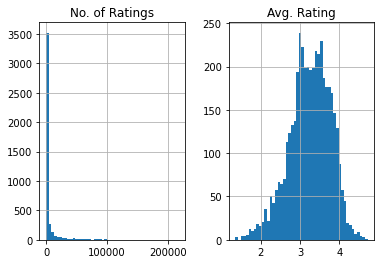

In [102]:
plt.figure(figsize=(15,15))
ratings.hist(bins=50)

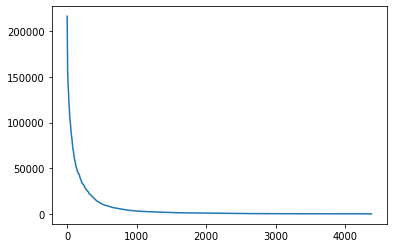

In [93]:
plt.plot(Ratings['No. of Ratings'].values)

<AxesSubplot:xlabel='No. of Ratings', ylabel='Avg. Rating'>

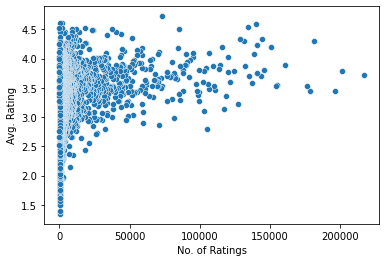

In [94]:
sns.scatterplot(y='Avg. Rating',x='No. of Ratings',data=ratings)

In [96]:
df_new['watched_year']=pd.DatetimeIndex(df_new['date']).year
df_new.head()

,movie_id,customer_id,rating,date,year_of_release,movie_title,watched_year
0,15105,510180,4,1999-11-11,1991.0,My Girl,1999
1,15105,261295,4,1999-12-24,1991.0,My Girl,1999
2,15105,1267764,5,1999-12-30,1991.0,My Girl,1999
3,15105,2105516,3,2000-01-06,1991.0,My Girl,2000
4,15105,2108672,3,2000-01-06,1991.0,My Girl,2000


In [97]:
df_new['watched_year'].value_counts()

2005    14302026
2004     7957031
2003     2579640
2002     1219406
2001      526771
2000      262084
1999         565
Name: watched_year, dtype: int64

<AxesSubplot:>

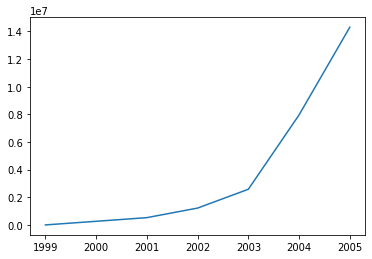

In [98]:
df_new['watched_year'].value_counts().plot()

<AxesSubplot:xlabel='watched_year', ylabel='count'>

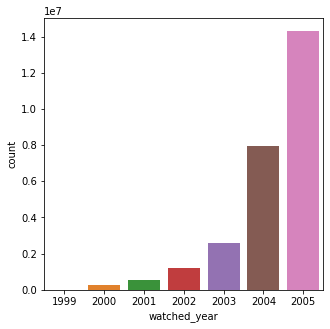

In [99]:
plt.figure(figsize=(5,5))
sns.countplot(data=df_new, x='watched_year')

In [105]:
cust_count=df_new.groupby(['customer_id']).count()['rating'].sort_values(ascending=False)
cust_ratings_mean=df_new.groupby(['customer_id']).mean()['rating'].sort_values(ascending=False)

In [107]:
cust_ratings=pd.concat([cust_count,cust_ratings_mean],axis=1)
cust_ratings.columns=['No. of Ratings','Avg. Rating']
cust_ratings.sort_values(by='No. of Ratings',inplace=True,ascending=False)
cust_ratings.head()

,No. of Ratings,Avg. Rating
customer_id,,
305344,4378,1.910918
387418,4310,1.804640
2439493,4126,1.229278
1664010,3908,4.286847
2118461,3688,4.102766


<AxesSubplot:>

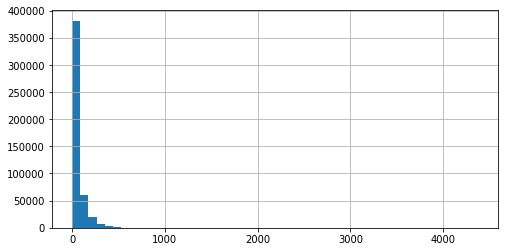

In [108]:
plt.figure(figsize=(8,4))
cust_count.hist(bins=50)

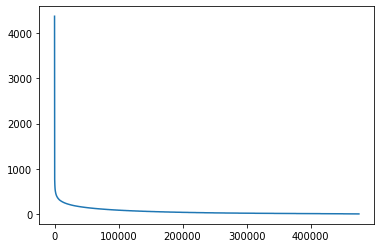

In [109]:
plt.plot(cust_count.values)

# 희소행렬과 연산

In [115]:
split_value = int(len(df_new) * 0.80)
train_data = df_new[:split_value]
test_data = df_new[split_value:]

In [116]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

In [117]:
train_sparse_data = get_user_item_sparse_matrix(train_data)
test_sparse_data = get_user_item_sparse_matrix(test_data)
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print(f"Global Average Rating: {global_average_rating}")

Global Average Rating: 3.6379720884860047


In [120]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [126]:
avg_rating_user = get_average_rating(train_sparse_data, True)
avg_rating_movie = get_average_rating(train_sparse_data, False)

In [123]:
total_users = len(np.unique(df_new["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
print(f"전체 사용자수 {total_users} 명")
print(f"평가에 참여한 사용자수 {train_users} 명")
print(f"평가에 참여하지 않은 사용자수 = {uncommonUsers} 명, 약 {np.round((uncommonUsers/total_users)*100)}%")

전체 사용자수 475601 명
평가에 참여한 사용자수 464904 명
평가에 참여하지 않은 사용자수 = 10697 명, 약 2.0%


In [128]:
total_movies = len(np.unique(df_new["movie_id"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
print(f"전체 영화 {total_movies} 편")
print(f"평가된 영화 {train_movies} 편")
print(f"평가되지 않은 영화 {uncommonMovies} 편, 약 {np.round((uncommonMovies/total_movies)*100)}%")

전체 영화 4403 편
평가된 영화 2769 편
평가되지 않은 영화 1634 편, 약 37.0%


# 유사도 계산

In [129]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    return similar_arr

In [130]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)
similar_user_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [136]:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return no_of_similar_movies

In [137]:
similar_movies = compute_movie_similarity_count(train_sparse_data, df_new, 1775)
print(f"영화의 유사도 {similar_movies}")

영화의 유사도 (2509840, 0)


In [138]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

In [139]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

In [140]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open('../dataset/recommendation/new_features.csv', mode = "w")

    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())

        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)

        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)

        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)

        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")

    new_features_csv_file.close()
    new_features_df = pd.read_csv('../dataset/recommendation/new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1",
                                                                                         "similar_user_rating2", "similar_user_rating3",
                                                                                         "similar_user_rating4", "similar_user_rating5",
                                                                                         "similar_movie_rating1", "similar_movie_rating2",
                                                                                         "similar_movie_rating3", "similar_movie_rating4",
                                                                                         "similar_movie_rating5", "user_average",
                                                                                         "movie_average", "rating"])
    return new_features_df

In [141]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,34413,13542,3.493711,5.0,1.0,3.0,3.0,5.0,4.0,4.0,3.000000,4.000000,4.000000,4.000000,3.727273,5.0
1,194727,13542,3.493711,4.0,3.0,5.0,5.0,3.0,3.0,5.0,4.000000,4.000000,4.000000,4.000000,3.727273,4.0
2,448827,13542,3.493711,3.0,5.0,3.0,4.0,4.0,5.0,5.0,4.000000,4.750000,4.750000,4.750000,3.727273,5.0
3,578525,13542,3.493711,5.0,3.0,5.0,5.0,1.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000,3.727273,5.0
4,1277960,13542,3.493711,3.0,5.0,3.0,1.0,4.0,5.0,3.0,4.333333,4.333333,4.333333,4.333333,3.727273,5.0


In [142]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,639795,14083,3.375,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.00,0.0
1,4491,14274,3.375,2.0,2.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.32,5.0
2,238705,14274,3.375,2.0,2.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,3.32,4.0
3,532654,14274,3.375,2.0,2.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.32,5.0
4,720837,14274,3.375,2.0,2.0,5.0,4.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,3.32,2.0


In [143]:
x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)
x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)
y_train = train_new_similar_features["rating"]
y_test = test_new_similar_features["rating"]

In [144]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [145]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[18:27:43] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=10, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [146]:
y_pred_test = clf.predict(x_test)
rmse_test = error_metrics(y_test, y_pred_test)
print(f"RMSE = {rmse_test}")

RMSE = 0.4584064224572341


In [147]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

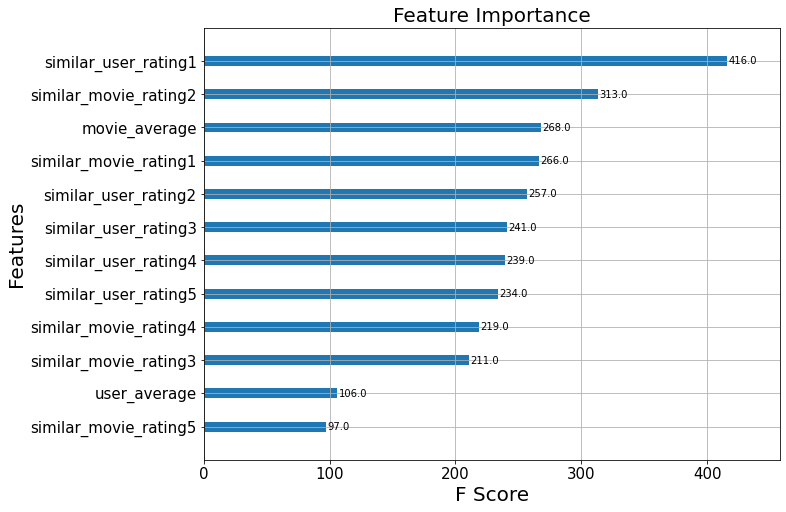

In [148]:
plot_importance(xgb, clf)